## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [1]:
# # скачиваем данные
# # если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

# !pip3 install gdown


# import gdown
# # train
# url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

# output = 'train.csv'
# gdown.download(url, output, quiet=True)

# # test
# url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

# output = 'test.csv'
# gdown.download(url, output, quiet=True)

# # user features
# url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
# output = 'users.csv'
# gdown.download(url, output, quiet=True, fuzzy=True)

# # item features
# url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
# output = 'items.csv'
# gdown.download(url, output, quiet=True)

In [ ]:
# Загрузим и изучим данные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from models (
    PopularityRecommender, 
    MatrixFactorizationRecommender, 
    NeuralRecommender,
    calculate_diversity,
    calculate_rank_based_overlap
)

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')

In [4]:

items = items.set_index('item_id')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Users shape:", users.shape)
print("Items shape:", items.shape)

print("\nTrain date range:")
print("Min date:", train['last_watch_dt'].min())
print("Max date:", train['last_watch_dt'].max())

print("\nTest date range:")
print("Min date:", test['last_watch_dt'].min())
print("Max date:", test['last_watch_dt'].max())

print("\nTarget distribution in train:")
print(train['target'].value_counts(normalize=True))

print("\nTarget distribution in test:")
print(test['target'].value_counts(normalize=True))

Train shape: (4866956, 6)
Test shape: (608467, 6)
Users shape: (840197, 5)
Items shape: (15963, 13)

Train date range:
Min date: 2021-03-13
Max date: 2021-08-12

Test date range:
Min date: 2021-08-13
Max date: 2021-08-22

Target distribution in train:
target
0    0.560344
1    0.439656
Name: proportion, dtype: float64

Target distribution in test:
target
0    0.650523
1    0.349477
Name: proportion, dtype: float64




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [5]:
train['last_watch_dt'] = pd.to_datetime(train['last_watch_dt'])
test['last_watch_dt'] = pd.to_datetime(test['last_watch_dt'])


train_dates = sorted(train['last_watch_dt'].unique())
split_idx = int(len(train_dates) * 0.8)
split_date = train_dates[split_idx]

print(f"Split date: {split_date}")
train_stage_1 = train[train['last_watch_dt'] < split_date].copy()
valid_stage_1 = train[train['last_watch_dt'] >= split_date].copy()

print(f"Train Stage 1 shape: {train_stage_1.shape}")
print(f"Valid Stage 1 shape: {valid_stage_1.shape}")

print("\nTarget distribution in train_stage_1:")
print(train_stage_1['target'].value_counts(normalize=True))

print("\nTarget distribution in valid_stage_1:")
print(valid_stage_1['target'].value_counts(normalize=True))

train_users = train_stage_1['user_id'].unique()
train_items = train_stage_1['item_id'].unique()
valid_users = valid_stage_1['user_id'].unique()
valid_items = valid_stage_1['item_id'].unique()


# Проверим наличие холодных пользователей и айтемов в valid_stage_1
cold_users = set(valid_users) - set(train_users)
cold_items = set(valid_items) - set(train_items)

print(f"\nCold users in valid_stage_1: {len(cold_users)} ({len(cold_users)/len(valid_users):.2%})")
print(f"Cold items in valid_stage_1: {len(cold_items)} ({len(cold_items)/len(valid_items):.2%})")


Split date: 2021-07-13 00:00:00
Train Stage 1 shape: (3280822, 6)
Valid Stage 1 shape: (1586134, 6)

Target distribution in train_stage_1:
target
0    0.535462
1    0.464538
Name: proportion, dtype: float64

Target distribution in valid_stage_1:
target
0    0.611809
1    0.388191
Name: proportion, dtype: float64

Cold users in valid_stage_1: 227551 (56.10%)
Cold items in valid_stage_1: 763 (7.59%)


In [6]:
# 1. Эвристическая модель - PopularityRecommender
popularity_model = PopularityRecommender(name="PopularityModel", weighted=True)
popularity_model.fit(train_stage_1)

# 2. Матричная факторизация
mf_model = MatrixFactorizationRecommender(n_factors=100, name="MatrixFactorizationModel")
mf_model.fit(train_stage_1)

# 3. Нейросетевая модель
nn_model = NeuralRecommender(
    embedding_dim=64, 
    hidden_layers=[128, 64], 
    batch_size=1024, 
    epochs=3,
    learning_rate=0.001, 
    name="NeuralRecommenderModel"
)
nn_model.fit(train_stage_1)


Fitting PopularityModel...
PopularityModel fitted successfully.
Fitting MatrixFactorizationModel...
MatrixFactorizationModel fitted successfully.
Fitting NeuralRecommenderModel...
Using device: cuda


Epoch 1/3:   0%|          | 0/3204 [00:00<?, ?it/s]

Epoch 1/3, Loss: 0.1478


Epoch 2/3:   0%|          | 0/3204 [00:00<?, ?it/s]

Epoch 2/3, Loss: 0.1313


Epoch 3/3:   0%|          | 0/3204 [00:00<?, ?it/s]

Epoch 3/3, Loss: 0.1250
NeuralRecommenderModel fitted successfully.


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [7]:
sample_users = valid_users[:3]
sample_items = valid_items[:3]


print("Sample predictions for user-item pairs:")
for user_id in sample_users:
    for item_id in sample_items:
        pop_score = popularity_model.predict_score(user_id, item_id)
        mf_score = mf_model.predict_score(user_id, item_id)
        nn_score = nn_model.predict_score(user_id, item_id)
        
        print(f"User {user_id}, Item {item_id}:")
        print(f"  Popularity score: {pop_score:.4f}")
        print(f"  Matrix Factorization score: {mf_score:.4f}")
        print(f"  Neural Network score: {nn_score:.4f}")
        print()

Sample predictions for user-item pairs:
User 204777, Item 7417:
  Popularity score: 0.1337
  Matrix Factorization score: 0.5088
  Neural Network score: 0.5438

User 204777, Item 4976:
  Popularity score: 0.0098
  Matrix Factorization score: 0.4863
  Neural Network score: 0.6339

User 204777, Item 4537:
  Popularity score: 0.0046
  Matrix Factorization score: 0.5049
  Neural Network score: 0.4439

User 1020160, Item 7417:
  Popularity score: 0.1337
  Matrix Factorization score: 0.5102
  Neural Network score: 0.6506

User 1020160, Item 4976:
  Popularity score: 0.0098
  Matrix Factorization score: 0.5257
  Neural Network score: 0.6929

User 1020160, Item 4537:
  Popularity score: 0.0046
  Matrix Factorization score: 0.8380
  Neural Network score: 0.5111

User 140353, Item 7417:
  Popularity score: 0.1337
  Matrix Factorization score: 0.5414
  Neural Network score: 0.6371

User 140353, Item 4976:
  Popularity score: 0.0098
  Matrix Factorization score: 0.6339
  Neural Network score: 0.673

In [8]:
k = 10
print(f"\nTop-{k} recommendations for sample users:")
for user_id in sample_users:
    print(f"\nUser {user_id}:")
    
    pop_recs = popularity_model.predict_top_k(user_id, k=k)
    mf_recs = mf_model.predict_top_k(user_id, k=k)
    nn_recs = nn_model.predict_top_k(user_id, k=k)
    
    print(f"  Popularity recommendations: {pop_recs}")
    print(f"  Matrix Factorization recommendations: {mf_recs}")
    print(f"  Neural Network recommendations: {nn_recs}")


Top-10 recommendations for sample users:

User 204777:
  Popularity recommendations: [15297, 10440, 13865, 9728, 3734, 4151, 142, 8636, 6809, 11237]
  Matrix Factorization recommendations: [5502, 13445, 14741, 13346, 2164, 21, 1226, 12747, 5674, 2545]
  Neural Network recommendations: [10859, 599, 11103, 936, 3446, 12719, 6853, 7132, 602, 10827]

User 1020160:
  Popularity recommendations: [15297, 10440, 13865, 9728, 3734, 4151, 142, 8636, 6809, 11237]
  Matrix Factorization recommendations: [1267, 11919, 9164, 10323, 15266, 11749, 6470, 15074, 11503, 7507]
  Neural Network recommendations: [10859, 599, 12719, 11103, 3446, 936, 6853, 7132, 602, 9465]

User 140353:
  Popularity recommendations: [15297, 10440, 13865, 9728, 3734, 4151, 142, 8636, 6809, 11237]
  Matrix Factorization recommendations: [15844, 9728, 10250, 9862, 8050, 3734, 689, 1523, 9972, 2269]
  Neural Network recommendations: [10859, 599, 12719, 6853, 3446, 11103, 936, 7132, 11592, 10827]


Generating recommendations for analysis...


Getting recommendations:   0%|          | 0/100 [00:00<?, ?it/s]


Calculating genre diversity...


Calculating diversity:   0%|          | 0/100 [00:00<?, ?it/s]


Average genre diversity:
  Popularity Model: 0.4000
  Matrix Factorization Model: 0.3645
  Neural Network Model: 0.3615


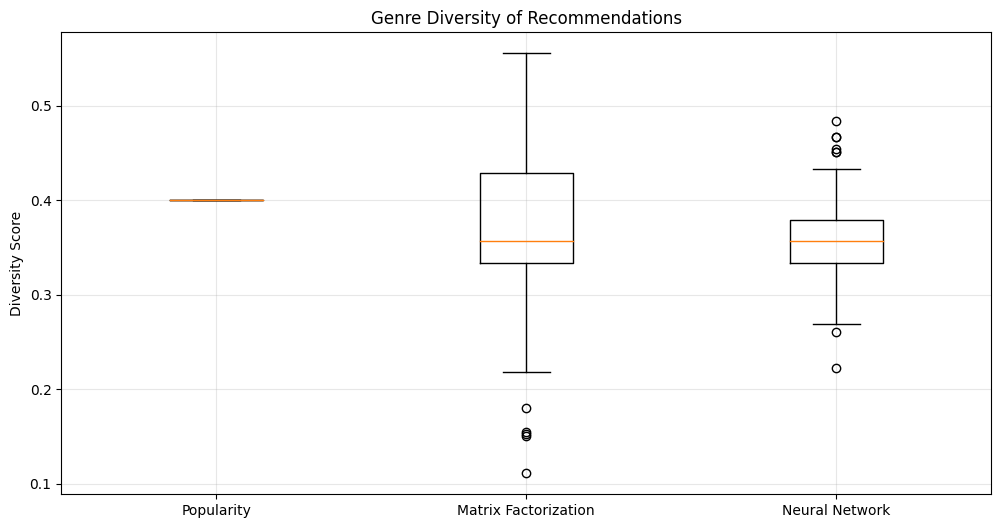

In [9]:
analysis_users = valid_users[:100]
k = 20  

print("Generating recommendations for analysis...")
pop_recommendations = {}
mf_recommendations = {}
nn_recommendations = {}

for user_id in tqdm(analysis_users, desc="Getting recommendations"):
    pop_recommendations[user_id] = popularity_model.predict_top_k(user_id, k=k)
    mf_recommendations[user_id] = mf_model.predict_top_k(user_id, k=k)
    nn_recommendations[user_id] = nn_model.predict_top_k(user_id, k=k)

# Анализ разнообразия рекомендаций по жанрам
print("\nCalculating genre diversity...")
pop_diversity = []
mf_diversity = []
nn_diversity = []

for user_id in tqdm(analysis_users, desc="Calculating diversity"):
    pop_diversity.append(calculate_diversity(pop_recommendations[user_id], items, 'genres'))
    mf_diversity.append(calculate_diversity(mf_recommendations[user_id], items, 'genres'))
    nn_diversity.append(calculate_diversity(nn_recommendations[user_id], items, 'genres'))

avg_pop_diversity = np.mean(pop_diversity)
avg_mf_diversity = np.mean(mf_diversity)
avg_nn_diversity = np.mean(nn_diversity)

print(f"\nAverage genre diversity:")
print(f"  Popularity Model: {avg_pop_diversity:.4f}")
print(f"  Matrix Factorization Model: {avg_mf_diversity:.4f}")
print(f"  Neural Network Model: {avg_nn_diversity:.4f}")


plt.figure(figsize=(12, 6))
plt.boxplot([pop_diversity, mf_diversity, nn_diversity], 
            labels=['Popularity', 'Matrix Factorization', 'Neural Network'])
plt.title('Genre Diversity of Recommendations')
plt.ylabel('Diversity Score')
plt.grid(True, alpha=0.3)
plt.show()


Calculating rank-based overlap between models...


Calculating RBO:   0%|          | 0/100 [00:00<?, ?it/s]


Average Rank-Based Overlap between models:
  Popularity vs Matrix Factorization: 0.0499
  Popularity vs Neural Network: 0.0041
  Matrix Factorization vs Neural Network: 0.1757


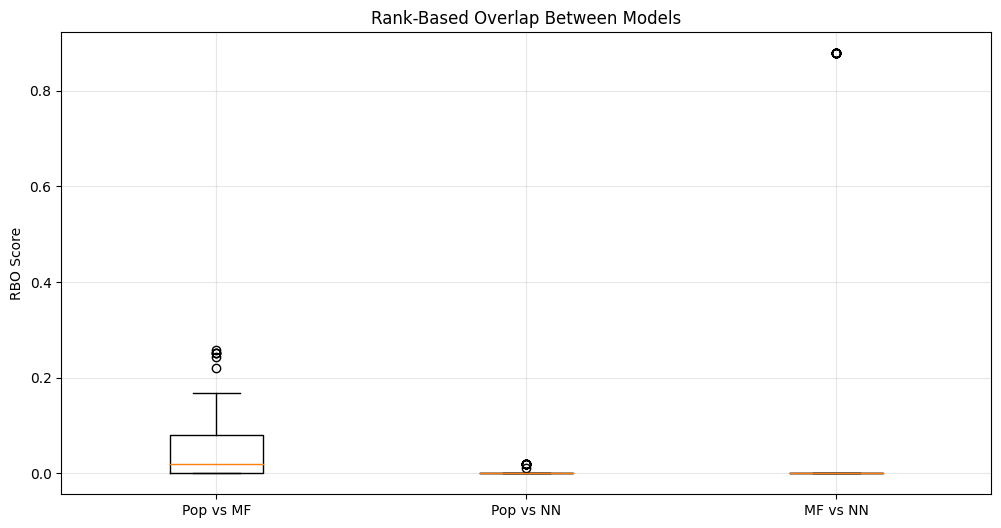

In [10]:
print("\nCalculating rank-based overlap between models...")
pop_mf_rbo = []
pop_nn_rbo = []
mf_nn_rbo = []

for user_id in tqdm(analysis_users, desc="Calculating RBO"):
    pop_mf_rbo.append(calculate_rank_based_overlap(pop_recommendations[user_id], mf_recommendations[user_id]))
    pop_nn_rbo.append(calculate_rank_based_overlap(pop_recommendations[user_id], nn_recommendations[user_id]))
    mf_nn_rbo.append(calculate_rank_based_overlap(mf_recommendations[user_id], nn_recommendations[user_id]))

avg_pop_mf_rbo = np.mean(pop_mf_rbo)
avg_pop_nn_rbo = np.mean(pop_nn_rbo)
avg_mf_nn_rbo = np.mean(mf_nn_rbo)

print(f"\nAverage Rank-Based Overlap between models:")
print(f"  Popularity vs Matrix Factorization: {avg_pop_mf_rbo:.4f}")
print(f"  Popularity vs Neural Network: {avg_pop_nn_rbo:.4f}")
print(f"  Matrix Factorization vs Neural Network: {avg_mf_nn_rbo:.4f}")

plt.figure(figsize=(12, 6))
plt.boxplot([pop_mf_rbo, pop_nn_rbo, mf_nn_rbo], 
            labels=['Pop vs MF', 'Pop vs NN', 'MF vs NN'])
plt.title('Rank-Based Overlap Between Models')
plt.ylabel('RBO Score')
plt.grid(True, alpha=0.3)
plt.show()


Analyzing common recommendations between models...


Calculating common items:   0%|          | 0/100 [00:00<?, ?it/s]

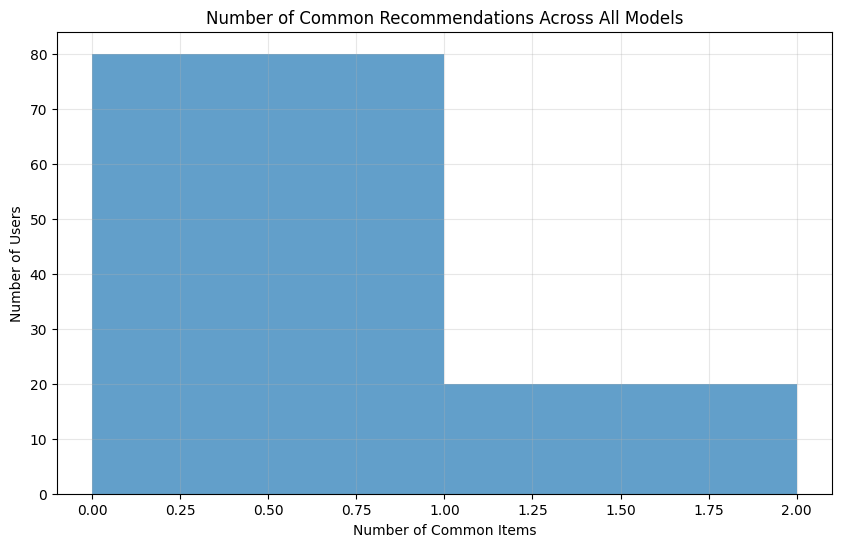


Average number of common recommendations across all models: 0.20 out of 20


In [11]:
# Анализ общих рекомендаций между моделями
print("\nAnalyzing common recommendations between models...")
common_items_count = []

for user_id in tqdm(analysis_users, desc="Calculating common items"):
    pop_items = set(pop_recommendations[user_id])
    mf_items = set(mf_recommendations[user_id])
    nn_items = set(nn_recommendations[user_id])
    
    common = pop_items.intersection(mf_items).intersection(nn_items)
    common_items_count.append(len(common))

plt.figure(figsize=(10, 6))
plt.hist(common_items_count, bins=range(0, max(common_items_count)+2), alpha=0.7)
plt.title('Number of Common Recommendations Across All Models')
plt.xlabel('Number of Common Items')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nAverage number of common recommendations across all models: {np.mean(common_items_count):.2f} out of {k}")



### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [12]:
valid_start_date = valid_stage_1['last_watch_dt'].min()
test_start_date = test['last_watch_dt'].min()

print(f"Valid stage 1 starts at: {valid_start_date}")
print(f"Test starts at: {test_start_date}")

Valid stage 1 starts at: 2021-07-13 00:00:00
Test starts at: 2021-08-13 00:00:00


In [13]:
def generate_features(interactions_df, target_df, users_df, items_df, cutoff_date):
    print(f"Generating features using data before {cutoff_date}")
    
    hist_data = interactions_df[interactions_df['last_watch_dt'] < cutoff_date].copy()
    result_df = target_df.copy()

    print("Adding model scores...")
    result_df['popularity_score'] = result_df.apply(
        lambda row: popularity_model.predict_score(row['user_id'], row['item_id']), axis=1
    )
    
    result_df['mf_score'] = result_df.apply(
        lambda row: mf_model.predict_score(row['user_id'], row['item_id']), axis=1
    )
    
    result_df['nn_score'] = result_df.apply(
        lambda row: nn_model.predict_score(row['user_id'], row['item_id']), axis=1
    )
    
    # 1. Признаки, относящиеся только к пользователю
    print("Generating user features...")
    
    # 1.1. Средний процент просмотра всех фильмов пользователем
    user_avg_watch = hist_data.groupby('user_id')['watched_pct'].mean().reset_index()
    user_avg_watch.columns = ['user_id', 'user_avg_watched_pct']
    result_df = result_df.merge(user_avg_watch, on='user_id', how='left')
    
    # 1.2. Количество уникальных фильмов, просмотренных пользователем
    user_unique_items = hist_data.groupby('user_id')['item_id'].nunique().reset_index()
    user_unique_items.columns = ['user_id', 'user_unique_items_count']
    result_df = result_df.merge(user_unique_items, on='user_id', how='left')

    result_df['user_avg_watched_pct'] = result_df['user_avg_watched_pct'].fillna(
        hist_data['watched_pct'].mean()
    )
    result_df['user_unique_items_count'] = result_df['user_unique_items_count'].fillna(0)
    
    # 2. Признаки, относящиеся только к айтему
    print("Generating item features...")
    
    # 2.1. Средний процент просмотра данного фильма всеми пользователями
    item_avg_watch = hist_data.groupby('item_id')['watched_pct'].mean().reset_index()
    item_avg_watch.columns = ['item_id', 'item_avg_watched_pct']
    result_df = result_df.merge(item_avg_watch, on='item_id', how='left')
    
    # 2.2. Количество пользователей, просмотревших данный фильм
    item_users_count = hist_data.groupby('item_id')['user_id'].nunique().reset_index()
    item_users_count.columns = ['item_id', 'item_users_count']
    result_df = result_df.merge(item_users_count, on='item_id', how='left')

    result_df['item_avg_watched_pct'] = result_df['item_avg_watched_pct'].fillna(
        hist_data['watched_pct'].mean()
    )
    result_df['item_users_count'] = result_df['item_users_count'].fillna(0)
    
    # 3. Признаки, показывающие связь пользователя и айтема
    print("Generating user-item interaction features...")
    
    hist_data_with_info = hist_data.merge(users_df[['user_id', 'age', 'sex']], on='user_id', how='left')

    items_genres = items_df['genres'].fillna('').str.split(',', expand=True).stack().reset_index()
    items_genres.columns = ['item_id', 'tmp', 'genre']
    items_genres['genre'] = items_genres['genre'].str.strip()
    items_genres = items_genres[items_genres['genre'] != '']
    items_genres = items_genres[['item_id', 'genre']]
    
    item_to_genres = items_genres.groupby('item_id')['genre'].apply(list).to_dict()
    
    def get_genres(item_id):
        return item_to_genres.get(item_id, [])
    
    # 3.1. Средний процент просмотра фильмов того же жанра пользователем
    print("Calculating genre-based features...")

    def calculate_user_genre_avg(row):
        user_id = row['user_id']
        item_id = row['item_id']
        
        item_genres = get_genres(item_id)
        
        if not item_genres:
            return None

        user_items = hist_data[hist_data['user_id'] == user_id]
        
        if user_items.empty:
            return None

        genre_items = []
        for _, user_item in user_items.iterrows():
            viewed_item_id = user_item['item_id']
            viewed_item_genres = get_genres(viewed_item_id)
            
            # Если есть пересечение по жанрам
            if set(item_genres) & set(viewed_item_genres):
                genre_items.append(user_item['watched_pct'])
        
        if not genre_items:
            return None
        
        return np.mean(genre_items)

    sample_size = min(10000, len(result_df))
    sample_indices = np.random.choice(result_df.index, sample_size, replace=False)
    
    result_df.loc[sample_indices, 'user_genre_avg_watched_pct'] = result_df.loc[sample_indices].apply(
        calculate_user_genre_avg, axis=1
    )
    mean_genre_watched = result_df.loc[sample_indices, 'user_genre_avg_watched_pct'].mean()
    result_df['user_genre_avg_watched_pct'] = result_df['user_genre_avg_watched_pct'].fillna(mean_genre_watched)
    
    # 3.2. Средний процент просмотра фильмов пользователями того же возраста
    print("Calculating age-based features...")
    
    age_item_avg = hist_data_with_info.groupby(['age', 'item_id'])['watched_pct'].mean().reset_index()
    age_item_avg.columns = ['age', 'item_id', 'age_item_avg_watched_pct']
    
    result_df = result_df.merge(
        users_df[['user_id', 'age']], on='user_id', how='left'
    ).merge(
        age_item_avg, on=['age', 'item_id'], how='left'
    )
    
    # 3.3. Средний процент просмотра фильмов пользователями того же пола
    print("Calculating gender-based features...")
    
    sex_item_avg = hist_data_with_info.groupby(['sex', 'item_id'])['watched_pct'].mean().reset_index()
    sex_item_avg.columns = ['sex', 'item_id', 'sex_item_avg_watched_pct']
    
    result_df = result_df.merge(
        users_df[['user_id', 'sex']], on='user_id', how='left'
    ).merge(
        sex_item_avg, on=['sex', 'item_id'], how='left'
    )
    
    # 3.4. Было ли взаимодействие пользователя с этим айтемом в прошлом
    print("Calculating previous interactions...")

    user_item_pairs = hist_data[['user_id', 'item_id']].drop_duplicates()
    user_item_pairs['had_previous_interaction'] = 1
    
    result_df = result_df.merge(user_item_pairs, on=['user_id', 'item_id'], how='left')
    result_df['had_previous_interaction'] = result_df['had_previous_interaction'].fillna(0)
    
    # 3.5. Количество дней с последнего взаимодействия пользователя с этим айтемом
    print("Calculating days since last interaction...")

    last_interaction = hist_data.groupby(['user_id', 'item_id'])['last_watch_dt'].max().reset_index()
    last_interaction.columns = ['user_id', 'item_id', 'last_interaction_date']

    result_df = result_df.merge(last_interaction, on=['user_id', 'item_id'], how='left')

    result_df['days_since_last_interaction'] = result_df.apply(
        lambda row: (cutoff_date - row['last_interaction_date']).days 
        if pd.notnull(row.get('last_interaction_date')) else 9999,
        axis=1
    )

    result_df = result_df.drop(columns=['last_interaction_date'], errors='ignore')
    
    print("Calculating duration-based features...")
    
    hist_data_with_duration = hist_data.copy()

    def duration_category(duration):
        if duration < 30*60:
            return 'short'
        elif duration < 90*60:
            return 'medium'
        else:
            return 'long'
    
    hist_data_with_duration['duration_category'] = hist_data_with_duration['total_dur'].apply(duration_category)
    
    user_duration_avg = hist_data_with_duration.groupby(['user_id', 'duration_category'])['watched_pct'].mean().reset_index()
    user_duration_avg.columns = ['user_id', 'duration_category', 'user_duration_avg_watched_pct']

    result_df['duration_category'] = result_df['total_dur'].apply(duration_category)

    result_df = result_df.merge(
        user_duration_avg, on=['user_id', 'duration_category'], how='left'
    )

    mean_duration_watched = hist_data_with_duration.groupby('duration_category')['watched_pct'].mean().to_dict()
    
    result_df['user_duration_avg_watched_pct'] = result_df.apply(
        lambda row: mean_duration_watched.get(row['duration_category'], hist_data['watched_pct'].mean())
        if pd.isnull(row['user_duration_avg_watched_pct']) else row['user_duration_avg_watched_pct'],
        axis=1
    )
    
    result_df['age_item_avg_watched_pct'] = result_df['age_item_avg_watched_pct'].fillna(
        hist_data['watched_pct'].mean()
    )
    result_df['sex_item_avg_watched_pct'] = result_df['sex_item_avg_watched_pct'].fillna(
        hist_data['watched_pct'].mean()
    )

    result_df = result_df.drop(columns=['duration_category'], errors='ignore')
    
    print(f"Generated {result_df.shape[1] - target_df.shape[1]} features")
    
    return result_df

In [14]:
print("Generating features for valid_stage_1...")
valid_dates = valid_stage_1['last_watch_dt'].unique()
valid_df_with_features = pd.DataFrame()

for date in tqdm(valid_dates, desc="Processing valid dates"):
    daily_data = valid_stage_1[valid_stage_1['last_watch_dt'] == date].copy()
    daily_features = generate_features(train_stage_1, daily_data, users, items, date)
    valid_df_with_features = pd.concat([valid_df_with_features, daily_features], ignore_index=True)

Generating features for valid_stage_1...


Processing valid dates:   0%|          | 0/31 [00:00<?, ?it/s]

Generating features using data before 2021-07-13 00:00:00
Adding model scores...
Generating user features...
Generating item features...
Generating user-item interaction features...
Calculating genre-based features...
Calculating age-based features...
Calculating gender-based features...
Calculating previous interactions...
Calculating days since last interaction...
Calculating duration-based features...
Generated 15 features
Generating features using data before 2021-07-14 00:00:00
Adding model scores...
Generating user features...
Generating item features...
Generating user-item interaction features...
Calculating genre-based features...
Calculating age-based features...
Calculating gender-based features...
Calculating previous interactions...
Calculating days since last interaction...
Calculating duration-based features...
Generated 15 features
Generating features using data before 2021-07-15 00:00:00
Adding model scores...
Generating user features...
Generating item features...
Gen

In [15]:
print("\nGenerating features for test...")
test_dates = test['last_watch_dt'].unique()
test_df_with_features = pd.DataFrame()

for date in tqdm(test_dates, desc="Processing test dates"):
    daily_data = test[test['last_watch_dt'] == date].copy()
    all_train = pd.concat([train_stage_1, valid_stage_1], ignore_index=True)
    daily_features = generate_features(all_train, daily_data, users, items, date)
    test_df_with_features = pd.concat([test_df_with_features, daily_features], ignore_index=True)


Generating features for test...


Processing test dates:   0%|          | 0/10 [00:00<?, ?it/s]

Generating features using data before 2021-08-13 00:00:00
Adding model scores...
Generating user features...
Generating item features...
Generating user-item interaction features...
Calculating genre-based features...
Calculating age-based features...
Calculating gender-based features...
Calculating previous interactions...
Calculating days since last interaction...
Calculating duration-based features...
Generated 15 features
Generating features using data before 2021-08-14 00:00:00
Adding model scores...
Generating user features...
Generating item features...
Generating user-item interaction features...
Calculating genre-based features...
Calculating age-based features...
Calculating gender-based features...
Calculating previous interactions...
Calculating days since last interaction...
Calculating duration-based features...
Generated 15 features
Generating features using data before 2021-08-15 00:00:00
Adding model scores...
Generating user features...
Generating item features...
Gen

In [16]:
print("\nValid features shape:", valid_df_with_features.shape)
print("Test features shape:", test_df_with_features.shape)

feature_columns = [col for col in valid_df_with_features.columns 
                   if col not in ['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct', 'target']]
print("\nGenerated features:")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i}. {feature}")

print("\nMissing values in valid features:")
print(valid_df_with_features[feature_columns].isnull().sum())

print("\nMissing values in test features:")
print(test_df_with_features[feature_columns].isnull().sum())


Valid features shape: (1586134, 21)
Test features shape: (608467, 21)

Generated features:
1. popularity_score
2. mf_score
3. nn_score
4. user_avg_watched_pct
5. user_unique_items_count
6. item_avg_watched_pct
7. item_users_count
8. user_genre_avg_watched_pct
9. age
10. age_item_avg_watched_pct
11. sex
12. sex_item_avg_watched_pct
13. had_previous_interaction
14. days_since_last_interaction
15. user_duration_avg_watched_pct

Missing values in valid features:
popularity_score                      0
mf_score                              0
nn_score                              0
user_avg_watched_pct                  0
user_unique_items_count               0
item_avg_watched_pct                  0
item_users_count                      0
user_genre_avg_watched_pct            0
age                              324111
age_item_avg_watched_pct              0
sex                              323765
sex_item_avg_watched_pct              0
had_previous_interaction              0
days_since_last_


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [17]:
import xgboost as xgb
import catboost as cb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import shap
import torch
from sklearn.preprocessing import LabelEncoder

In [18]:
print("Preparing data for ranker training...")
feature_columns = [col for col in valid_df_with_features.columns 
                  if col not in ['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct', 'target']]

X_train, X_val, y_train, y_val = train_test_split(
    valid_df_with_features[feature_columns],
    valid_df_with_features['target'],
    test_size=0.2,
    random_state=42,
    stratify=valid_df_with_features['target']
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

print(f"Target distribution in training set: {y_train.value_counts(normalize=True)}")
print(f"Target distribution in validation set: {y_val.value_counts(normalize=True)}")

Preparing data for ranker training...
Training set shape: (1268907, 15)
Validation set shape: (317227, 15)
Target distribution in training set: target
0    0.611809
1    0.388191
Name: proportion, dtype: float64
Target distribution in validation set: target
0    0.611808
1    0.388192
Name: proportion, dtype: float64


In [19]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
if categorical_features:
    print(f"\nFound categorical features: {categorical_features}")

    label_encoders = {}
    for feature in categorical_features:
        le = LabelEncoder()
        combined_data = pd.concat([X_train[feature], X_val[feature]], axis=0)
        le.fit(combined_data.fillna('unknown'))
        
        X_train[feature] = le.transform(X_train[feature].fillna('unknown'))
        X_val[feature] = le.transform(X_val[feature].fillna('unknown'))
        
        label_encoders[feature] = le


Found categorical features: ['age', 'sex']


In [20]:
print("\nTraining XGBoost classifier...")
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1),  # Для несбалансированных данных
    'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',  # Используем GPU если доступен
    'random_state': 42,
    'early_stopping_rounds': 20,
}

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)
xgb_val_preds = xgb_model.predict_proba(X_val)[:, 1]
xgb_val_preds_binary = (xgb_val_preds > 0.5).astype(int)

print("\nXGBoost performance on validation set:")
print(f"AUC: {roc_auc_score(y_val, xgb_val_preds):.4f}")
print(f"Accuracy: {accuracy_score(y_val, xgb_val_preds_binary):.4f}")
print(f"Precision: {precision_score(y_val, xgb_val_preds_binary):.4f}")
print(f"Recall: {recall_score(y_val, xgb_val_preds_binary):.4f}")
print(f"F1 Score: {f1_score(y_val, xgb_val_preds_binary):.4f}")


Training XGBoost classifier...
[0]	validation_0-auc:0.94937
[1]	validation_0-auc:0.94942
[2]	validation_0-auc:0.95037
[3]	validation_0-auc:0.95108
[4]	validation_0-auc:0.95128
[5]	validation_0-auc:0.95131
[6]	validation_0-auc:0.95157
[7]	validation_0-auc:0.95173
[8]	validation_0-auc:0.95207
[9]	validation_0-auc:0.95232
[10]	validation_0-auc:0.95209
[11]	validation_0-auc:0.95233
[12]	validation_0-auc:0.95250
[13]	validation_0-auc:0.95276
[14]	validation_0-auc:0.95306
[15]	validation_0-auc:0.95325
[16]	validation_0-auc:0.95349
[17]	validation_0-auc:0.95349
[18]	validation_0-auc:0.95367
[19]	validation_0-auc:0.95383
[20]	validation_0-auc:0.95399
[21]	validation_0-auc:0.95404
[22]	validation_0-auc:0.95422
[23]	validation_0-auc:0.95423
[24]	validation_0-auc:0.95438
[25]	validation_0-auc:0.95454
[26]	validation_0-auc:0.95463
[27]	validation_0-auc:0.95470
[28]	validation_0-auc:0.95483
[29]	validation_0-auc:0.95493
[30]	validation_0-auc:0.95501
[31]	validation_0-auc:0.95506
[32]	validation_0-

In [21]:
X_train_cb = X_train.copy()
X_val_cb = X_val.copy()

print("\nTraining CatBoost classifier...")
categorical_indices = [X_train_cb.columns.get_loc(col) for col in categorical_features] if categorical_features else None

cb_params = {
    'iterations': 200,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',  # Используем GPU если доступен
    'verbose': 100,
}

cb_model = cb.CatBoostClassifier(**cb_params)
cb_model.fit(
    X_train_cb, y_train,
    eval_set=(X_val_cb, y_val),
    cat_features=categorical_indices,
    early_stopping_rounds=20,
    verbose=True
)

cb_val_preds = cb_model.predict_proba(X_val_cb)[:, 1]
cb_val_preds_binary = (cb_val_preds > 0.5).astype(int)

print("\nCatBoost performance on validation set:")
print(f"AUC: {roc_auc_score(y_val, cb_val_preds):.4f}")
print(f"Accuracy: {accuracy_score(y_val, cb_val_preds_binary):.4f}")
print(f"Precision: {precision_score(y_val, cb_val_preds_binary):.4f}")
print(f"Recall: {recall_score(y_val, cb_val_preds_binary):.4f}")
print(f"F1 Score: {f1_score(y_val, cb_val_preds_binary):.4f}")


Training CatBoost classifier...


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9418989	best: 0.9418989 (0)	total: 20.5ms	remaining: 4.08s
1:	total: 36.3ms	remaining: 3.59s
2:	total: 51.8ms	remaining: 3.4s
3:	total: 67.5ms	remaining: 3.31s
4:	total: 83.1ms	remaining: 3.24s
5:	test: 0.9480202	best: 0.9480202 (5)	total: 98.9ms	remaining: 3.2s
6:	total: 115ms	remaining: 3.16s
7:	total: 130ms	remaining: 3.12s
8:	total: 146ms	remaining: 3.09s
9:	total: 161ms	remaining: 3.06s
10:	test: 0.9495765	best: 0.9495765 (10)	total: 177ms	remaining: 3.04s
11:	total: 192ms	remaining: 3.01s
12:	total: 208ms	remaining: 2.99s
13:	total: 223ms	remaining: 2.97s
14:	total: 239ms	remaining: 2.95s
15:	test: 0.9506760	best: 0.9506760 (15)	total: 255ms	remaining: 2.93s
16:	total: 270ms	remaining: 2.91s
17:	total: 286ms	remaining: 2.89s
18:	total: 301ms	remaining: 2.87s
19:	total: 317ms	remaining: 2.85s
20:	test: 0.9513313	best: 0.9513313 (20)	total: 333ms	remaining: 2.83s
21:	total: 348ms	remaining: 2.82s
22:	total: 364ms	remaining: 2.8s
23:	total: 380ms	remaining: 2.78s
24:	tota

In [22]:
xgb_auc = roc_auc_score(y_val, xgb_val_preds)
cb_auc = roc_auc_score(y_val, cb_val_preds)

if xgb_auc > cb_auc:
    print("\nXGBoost performs better. Using it as the final ranker.")
    final_model = xgb_model
    model_name = "XGBoost"
    final_encoders = label_encoders
    final_X_test = X_test = test_df_with_features[feature_columns].copy()
    for feature in categorical_features:
        final_X_test[feature] = final_encoders[feature].transform(final_X_test[feature].fillna('unknown'))
else:
    print("\nCatBoost performs better. Using it as the final ranker.")
    final_model = cb_model
    model_name = "CatBoost"
    final_X_test = test_df_with_features[feature_columns].copy()

print("\nAnalyzing model performance on cold users...")

# Определяем холодных пользователей в тесте
train_users = set(train_stage_1['user_id'].unique())
test_users = set(test['user_id'].unique())
cold_users = test_users - train_users

cold_mask = test_df_with_features['user_id'].isin(cold_users)
warm_mask = ~cold_mask

X_test_cold = final_X_test[cold_mask]
y_test_cold = test_df_with_features[cold_mask]['target']

X_test_warm = final_X_test[warm_mask]
y_test_warm = test_df_with_features[warm_mask]['target']

print(f"Cold users in test: {len(cold_users)} ({len(X_test_cold) / len(test_df_with_features):.2%} of test data)")
print(f"Warm users in test: {len(test_users - cold_users)} ({len(X_test_warm) / len(test_df_with_features):.2%} of test data)")


XGBoost performs better. Using it as the final ranker.

Analyzing model performance on cold users...
Cold users in test: 137991 (62.79% of test data)
Warm users in test: 78408 (37.21% of test data)


In [23]:
if len(X_test_cold) > 0:
    cold_preds = final_model.predict_proba(X_test_cold)[:, 1]
    cold_preds_binary = (cold_preds > 0.5).astype(int)
    
    print(f"\n{model_name} performance on cold users:")
    print(f"AUC: {roc_auc_score(y_test_cold, cold_preds):.4f}")
    print(f"Accuracy: {accuracy_score(y_test_cold, cold_preds_binary):.4f}")
    print(f"Precision: {precision_score(y_test_cold, cold_preds_binary):.4f}")
    print(f"Recall: {recall_score(y_test_cold, cold_preds_binary):.4f}")
    print(f"F1 Score: {f1_score(y_test_cold, cold_preds_binary):.4f}")

warm_preds = final_model.predict_proba(X_test_warm)[:, 1]
warm_preds_binary = (warm_preds > 0.5).astype(int)

print(f"\n{model_name} performance on warm users:")
print(f"AUC: {roc_auc_score(y_test_warm, warm_preds):.4f}")
print(f"Accuracy: {accuracy_score(y_test_warm, warm_preds_binary):.4f}")
print(f"Precision: {precision_score(y_test_warm, warm_preds_binary):.4f}")
print(f"Recall: {recall_score(y_test_warm, warm_preds_binary):.4f}")
print(f"F1 Score: {f1_score(y_test_warm, warm_preds_binary):.4f}")


y_test = test_df_with_features['target']

test_preds = final_model.predict_proba(final_X_test)[:, 1]
test_preds_binary = (test_preds > 0.5).astype(int)

print(f"\n{model_name} performance on entire test set:")
print(f"AUC: {roc_auc_score(y_test, test_preds):.4f}")
print(f"Accuracy: {accuracy_score(y_test, test_preds_binary):.4f}")
print(f"Precision: {precision_score(y_test, test_preds_binary):.4f}")
print(f"Recall: {recall_score(y_test, test_preds_binary):.4f}")
print(f"F1 Score: {f1_score(y_test, test_preds_binary):.4f}")


XGBoost performance on cold users:
AUC: 0.9514
Accuracy: 0.8772
Precision: 0.7624
Recall: 0.9245
F1 Score: 0.8357

XGBoost performance on warm users:
AUC: 0.9471
Accuracy: 0.8662
Precision: 0.7685
Recall: 0.9126
F1 Score: 0.8344

XGBoost performance on entire test set:
AUC: 0.9499
Accuracy: 0.8731
Precision: 0.7648
Recall: 0.9198
F1 Score: 0.8352



Feature importance analysis...


<Figure size 1200x800 with 0 Axes>

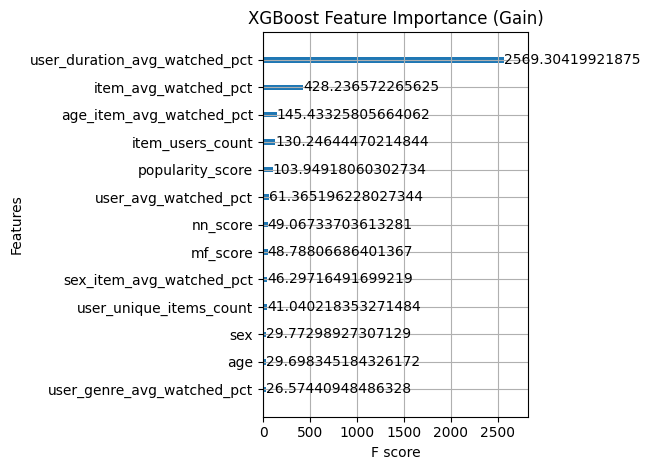

Top 15 most important features:
                          Feature   Importance
0   user_duration_avg_watched_pct  2569.304199
1            item_avg_watched_pct   428.236572
2        age_item_avg_watched_pct   145.433258
3                item_users_count   130.246445
4                popularity_score   103.949181
5            user_avg_watched_pct    61.365196
6                        nn_score    49.067337
7                        mf_score    48.788067
8        sex_item_avg_watched_pct    46.297165
9         user_unique_items_count    41.040218
10                            sex    29.772989
11                            age    29.698345
12     user_genre_avg_watched_pct    26.574409

No obvious data leaks detected in feature importance.


In [24]:
print("\nFeature importance analysis...")

if model_name == "XGBoost":
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(final_model, max_num_features=15, importance_type='gain')
    plt.title('XGBoost Feature Importance (Gain)')
    plt.tight_layout()
    plt.show()

    feature_importance = final_model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print("Top 15 most important features:")
    print(importance_df.head(15))

    max_importance = importance_df['Importance'].max()
    second_max = importance_df.iloc[1]['Importance'] if len(importance_df) > 1 else 0
    
    if max_importance > second_max * 10:
        print(f"\nWARNING: Potential data leak detected! The most important feature is {max_importance/second_max:.1f} times more important than the second one.")
    else:
        print("\nNo obvious data leaks detected in feature importance.")
    
else:
    plt.figure(figsize=(12, 8))
    feature_importance = final_model.get_feature_importance()
    sorted_idx = np.argsort(feature_importance)[-15:]
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), np.array(feature_columns)[sorted_idx])
    plt.title('CatBoost Feature Importance')
    plt.tight_layout()
    plt.show()

    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': feature_importance
    })
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print("Top 15 most important features:")
    print(importance_df.head(15))
    
    max_importance = importance_df['Importance'].max()
    second_max = importance_df.iloc[1]['Importance'] if len(importance_df) > 1 else 0
    
    if max_importance > second_max * 10:
        print(f"\nWARNING: Potential data leak detected! The most important feature is {max_importance/second_max:.1f} times more important than the second one.")
    else:
        print("\nNo obvious data leaks detected in feature importance.")


Running SHAP analysis...


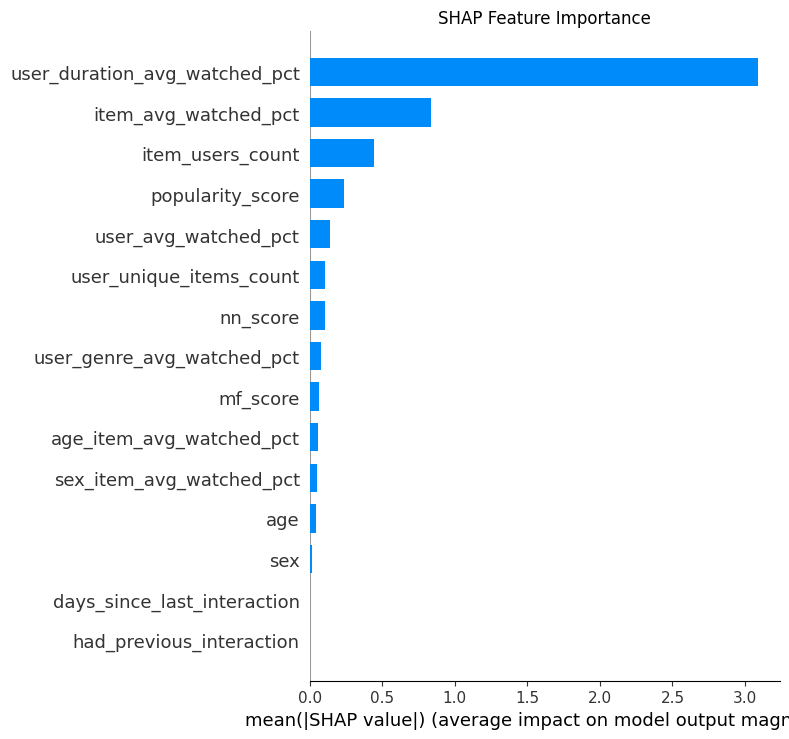

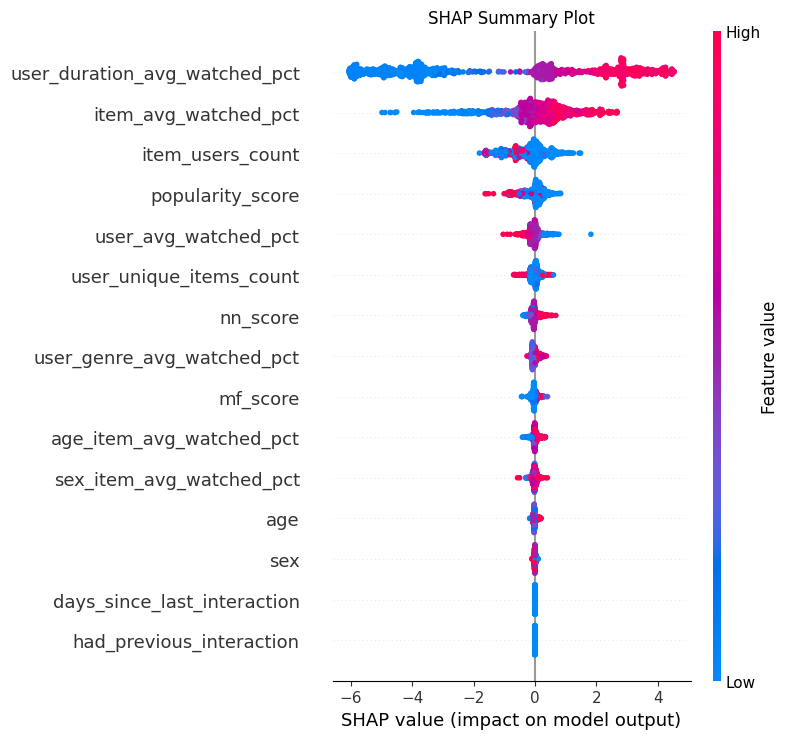

<Figure size 1000x600 with 0 Axes>

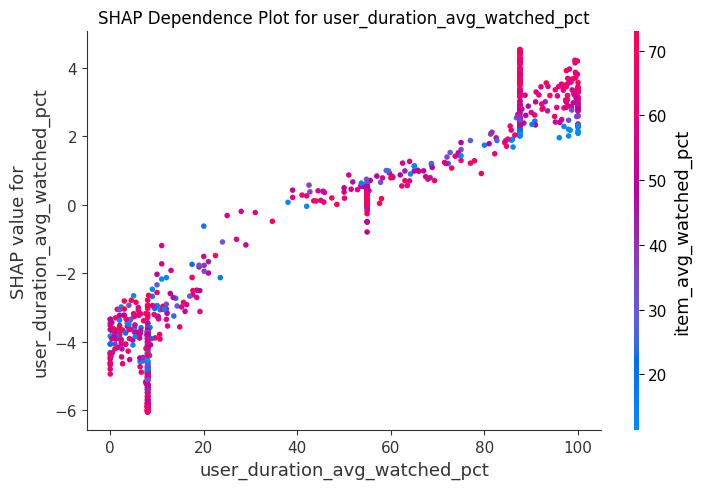

<Figure size 1000x600 with 0 Axes>

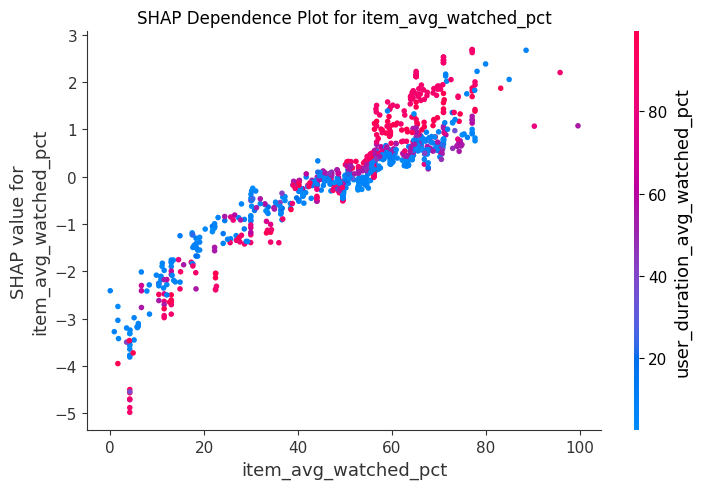

<Figure size 1000x600 with 0 Axes>

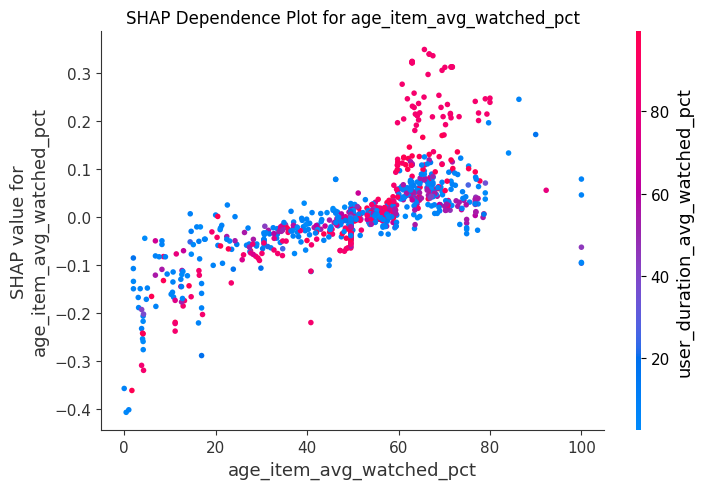


SHAP Analysis Interpretation:
1. Features with high absolute SHAP values have the most impact on predictions
2. Red points indicate higher feature values, blue points indicate lower feature values
3. Points to the right of the y-axis increase the prediction, points to the left decrease it

Feature Analysis Conclusion:
1. Most important features according to XGBoost:
   - user_duration_avg_watched_pct: 2569.30
   - item_avg_watched_pct: 428.24
   - age_item_avg_watched_pct: 145.43
   - item_users_count: 130.25
   - popularity_score: 103.95

2. Interpretation of key features:


In [25]:
print("\nRunning SHAP analysis...")

if model_name == "XGBoost":
    explainer = shap.TreeExplainer(final_model)
    shap_sample_size = min(1000, len(X_val))
    X_shap = X_val.iloc[:shap_sample_size]
    shap_values = explainer.shap_values(X_shap)

    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_values, X_shap, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()

    top_features = importance_df['Feature'].head(3).tolist()
    for feature in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feature, shap_values, X_shap, show=False)
        plt.title(f'SHAP Dependence Plot for {feature}')
        plt.tight_layout()
        plt.show()
    
else:
    explainer = shap.TreeExplainer(final_model)

    shap_sample_size = min(1000, len(X_val))
    X_shap = X_val.iloc[:shap_sample_size]

    shap_values = explainer.shap_values(X_shap)

    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_values, X_shap, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()

    top_features = importance_df['Feature'].head(3).tolist()
    for feature in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feature, shap_values, X_shap, show=False)
        plt.title(f'SHAP Dependence Plot for {feature}')
        plt.tight_layout()
        plt.show()

print("\nSHAP Analysis Interpretation:")
print("1. Features with high absolute SHAP values have the most impact on predictions")
print("2. Red points indicate higher feature values, blue points indicate lower feature values")
print("3. Points to the right of the y-axis increase the prediction, points to the left decrease it")

print("\nFeature Analysis Conclusion:")
print(f"1. Most important features according to {model_name}:")
for i, row in importance_df.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.2f}")

print("\n2. Interpretation of key features:")


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [26]:
# 1. Обучить модели первого уровня на всех (train+test) данных
print("Step 1: Training first-level models on all data...")

all_data = pd.concat([train, test], ignore_index=True)
print("Training PopularityRecommender on all data...")
all_popularity_model = PopularityRecommender(name="AllDataPopularityModel", weighted=True)
all_popularity_model.fit(all_data)

print("Training MatrixFactorizationRecommender on all data...")
all_mf_model = MatrixFactorizationRecommender(n_factors=100, name="AllDataMatrixFactorizationModel")
all_mf_model.fit(all_data)

print("Training NeuralRecommender on all data...")
all_nn_model = NeuralRecommender(
    embedding_dim=64, 
    hidden_layers=[128, 64], 
    batch_size=1024, 
    epochs=3,
    learning_rate=0.001, 
    name="AllDataNeuralRecommenderModel"
)
all_nn_model.fit(all_data)

Step 1: Training first-level models on all data...
Training PopularityRecommender on all data...
Fitting AllDataPopularityModel...
AllDataPopularityModel fitted successfully.
Training MatrixFactorizationRecommender on all data...
Fitting AllDataMatrixFactorizationModel...
AllDataMatrixFactorizationModel fitted successfully.
Training NeuralRecommender on all data...
Fitting AllDataNeuralRecommenderModel...
Using device: cuda


Epoch 1/3:   0%|          | 0/5348 [00:00<?, ?it/s]

Epoch 1/3, Loss: 0.1404


Epoch 2/3:   0%|          | 0/5348 [00:00<?, ?it/s]

Epoch 2/3, Loss: 0.1286


Epoch 3/3:   0%|          | 0/5348 [00:00<?, ?it/s]

Epoch 3/3, Loss: 0.1241
AllDataNeuralRecommenderModel fitted successfully.


In [27]:
# 2. Для каждой модели первого уровня для каждого пользователя сгенерировать N кандидатов
print("\nStep 2: Generating candidates from each model...")

N = 50 
k = 20

all_users = all_data['user_id'].unique()
all_items = all_data['item_id'].unique()

print(f"Total users: {len(all_users)}")
print(f"Total items: {len(all_items)}")

sample_size = min(1000, len(all_users))
sample_users = np.random.choice(all_users, sample_size, replace=False)
print(f"Using {sample_size} sample users for demonstration")

print("Generating candidates from PopularityRecommender...")
pop_candidates = all_popularity_model.batch_predict_top_k(sample_users, k=N)

print("Generating candidates from MatrixFactorizationRecommender...")
mf_candidates = all_mf_model.batch_predict_top_k(sample_users, k=N)

print("Generating candidates from NeuralRecommender...")
nn_candidates = all_nn_model.batch_predict_top_k(sample_users, k=N)


Step 2: Generating candidates from each model...
Total users: 962151
Total items: 15605
Using 1000 sample users for demonstration
Generating candidates from PopularityRecommender...


AllDataPopularityModel batch predict:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating candidates from MatrixFactorizationRecommender...


AllDataMatrixFactorizationModel batch predict:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating candidates from NeuralRecommender...


AllDataNeuralRecommenderModel batch predict:   0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
# 3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей
print("\nStep 3: Merging candidates and calculating scores...")

merged_candidates = {}
for user_id in tqdm(sample_users, desc="Merging candidates"):
    user_candidates = set(pop_candidates.get(user_id, []) + 
                          mf_candidates.get(user_id, []) + 
                          nn_candidates.get(user_id, []))

    candidate_scores = {}
    
    for item_id in user_candidates:
        pop_score = all_popularity_model.predict_score(user_id, item_id)
        mf_score = all_mf_model.predict_score(user_id, item_id)
        nn_score = all_nn_model.predict_score(user_id, item_id)
        candidate_scores[item_id] = {
            'popularity_score': pop_score,
            'mf_score': mf_score,
            'nn_score': nn_score
        }
    
    merged_candidates[user_id] = candidate_scores

candidate_dfs = []
for user_id, candidates in tqdm(merged_candidates.items(), desc="Creating candidate dataframes"):
    if not candidates:
        continue
        
    user_df = pd.DataFrame([
        {
            'user_id': user_id,
            'item_id': item_id,
            'popularity_score': scores['popularity_score'],
            'mf_score': scores['mf_score'],
            'nn_score': scores['nn_score']
        }
        for item_id, scores in candidates.items()
    ])
    
    candidate_dfs.append(user_df)

all_candidates_df = pd.concat(candidate_dfs, ignore_index=True)
print(f"Total candidate pairs: {len(all_candidates_df)}")


Step 3: Merging candidates and calculating scores...


Merging candidates:   0%|          | 0/1000 [00:00<?, ?it/s]

Creating candidate dataframes:   0%|          | 0/1000 [00:00<?, ?it/s]

Total candidate pairs: 148246


In [29]:
# 4. Собрать фичи для кандидатов (теперь можем считать признаки на всех данных)
print("\nStep 4: Collecting features for candidates...")

def generate_inference_features(all_interactions, candidate_df, users_df, items_df):

    print(f"Generating features for {len(candidate_df)} candidate pairs")
    
    result_df = candidate_df.copy()
    
    # 1. Признаки, относящиеся только к пользователю
    print("Generating user features...")
    
    # 1.1. Средний процент просмотра всех фильмов пользователем
    user_avg_watch = all_interactions.groupby('user_id')['watched_pct'].mean().reset_index()
    user_avg_watch.columns = ['user_id', 'user_avg_watched_pct']
    result_df = result_df.merge(user_avg_watch, on='user_id', how='left')
    
    # 1.2. Количество уникальных фильмов, просмотренных пользователем
    user_unique_items = all_interactions.groupby('user_id')['item_id'].nunique().reset_index()
    user_unique_items.columns = ['user_id', 'user_unique_items_count']
    result_df = result_df.merge(user_unique_items, on='user_id', how='left')
    
    result_df['user_avg_watched_pct'] = result_df['user_avg_watched_pct'].fillna(
        all_interactions['watched_pct'].mean()
    )
    result_df['user_unique_items_count'] = result_df['user_unique_items_count'].fillna(0)
    
    # 2. Признаки, относящиеся только к айтему
    print("Generating item features...")
    
    # 2.1. Средний процент просмотра данного фильма всеми пользователями
    item_avg_watch = all_interactions.groupby('item_id')['watched_pct'].mean().reset_index()
    item_avg_watch.columns = ['item_id', 'item_avg_watched_pct']
    result_df = result_df.merge(item_avg_watch, on='item_id', how='left')
    
    # 2.2. Количество пользователей, просмотревших данный фильм
    item_users_count = all_interactions.groupby('item_id')['user_id'].nunique().reset_index()
    item_users_count.columns = ['item_id', 'item_users_count']
    result_df = result_df.merge(item_users_count, on='item_id', how='left')
    
    # Заполняем пропуски в признаках айтема средними значениями
    result_df['item_avg_watched_pct'] = result_df['item_avg_watched_pct'].fillna(
        all_interactions['watched_pct'].mean()
    )
    result_df['item_users_count'] = result_df['item_users_count'].fillna(0)
    
    # 3. Признаки, показывающие связь пользователя и айтема
    print("Generating user-item interaction features...")

    interactions_with_info = all_interactions.merge(users_df[['user_id', 'age', 'sex']], on='user_id', how='left')
    items_genres = items_df['genres'].fillna('').str.split(',', expand=True).stack().reset_index()
    items_genres.columns = ['item_id', 'tmp', 'genre']
    items_genres['genre'] = items_genres['genre'].str.strip()
    items_genres = items_genres[items_genres['genre'] != '']
    items_genres = items_genres[['item_id', 'genre']]
    item_to_genres = items_genres.groupby('item_id')['genre'].apply(list).to_dict()
    
    # 3.1. Средний процент просмотра фильмов пользователями того же возраста
    print("Calculating age-based features...")

    age_item_avg = interactions_with_info.groupby(['age', 'item_id'])['watched_pct'].mean().reset_index()
    age_item_avg.columns = ['age', 'item_id', 'age_item_avg_watched_pct']

    result_df = result_df.merge(
        users_df[['user_id', 'age']], on='user_id', how='left'
    ).merge(
        age_item_avg, on=['age', 'item_id'], how='left'
    )
    
    # 3.2. Средний процент просмотра фильмов пользователями того же пола
    print("Calculating gender-based features...")

    sex_item_avg = interactions_with_info.groupby(['sex', 'item_id'])['watched_pct'].mean().reset_index()
    sex_item_avg.columns = ['sex', 'item_id', 'sex_item_avg_watched_pct']

    result_df = result_df.merge(
        users_df[['user_id', 'sex']], on='user_id', how='left'
    ).merge(
        sex_item_avg, on=['sex', 'item_id'], how='left'
    )
    
    # 3.3. Было ли взаимодействие пользователя с этим айтемом в прошлом
    print("Calculating previous interactions...")

    user_item_pairs = all_interactions[['user_id', 'item_id']].drop_duplicates()
    user_item_pairs['had_previous_interaction'] = 1
    
    result_df = result_df.merge(user_item_pairs, on=['user_id', 'item_id'], how='left')
    result_df['had_previous_interaction'] = result_df['had_previous_interaction'].fillna(0)
    
    # 3.4. Количество дней с последнего взаимодействия пользователя с этим айтемом
    print("Calculating days since last interaction...")

    all_interactions['last_watch_dt'] = pd.to_datetime(all_interactions['last_watch_dt'])
    last_interaction = all_interactions.groupby(['user_id', 'item_id'])['last_watch_dt'].max().reset_index()
    last_interaction.columns = ['user_id', 'item_id', 'last_interaction_date']

    result_df = result_df.merge(last_interaction, on=['user_id', 'item_id'], how='left')
    
    max_date = all_interactions['last_watch_dt'].max()
    result_df['days_since_last_interaction'] = result_df.apply(
        lambda row: (max_date - row['last_interaction_date']).days 
        if pd.notnull(row.get('last_interaction_date')) else 9999,
        axis=1
    )

    result_df = result_df.drop(columns=['last_interaction_date'], errors='ignore')
    
    # 3.5. Средняя длительность просмотра фильмов схожей продолжительности
    print("Calculating duration-based features...")

    items_duration = all_interactions[['item_id', 'total_dur']].drop_duplicates()
    items_duration = items_duration.groupby('item_id')['total_dur'].mean().reset_index()
    result_df = result_df.merge(items_duration, on='item_id', how='left')
    def duration_category(duration):
        if pd.isnull(duration):
            return 'unknown'
        if duration < 30*60:
            return 'short'
        elif duration < 90*60:
            return 'medium'
        else:
            return 'long'
    
    all_interactions['duration_category'] = all_interactions['total_dur'].apply(duration_category)
    result_df['duration_category'] = result_df['total_dur'].apply(duration_category)
    user_duration_avg = all_interactions.groupby(['user_id', 'duration_category'])['watched_pct'].mean().reset_index()
    user_duration_avg.columns = ['user_id', 'duration_category', 'user_duration_avg_watched_pct']

    result_df = result_df.merge(
        user_duration_avg, on=['user_id', 'duration_category'], how='left'
    )
    
    # 3.6. Жанровые предпочтения пользователя
    print("Calculating genre preferences...")

    def get_genres(item_id):
        return item_to_genres.get(item_id, [])

    result_df['genres_list'] = result_df['item_id'].apply(get_genres)
    
    user_genre_counts = {}

    for _, row in tqdm(all_interactions.iterrows(), total=len(all_interactions), desc="Calculating user genre counts"):
        user_id = row['user_id']
        item_id = row['item_id']
        
        if user_id not in user_genre_counts:
            user_genre_counts[user_id] = {}
        
        for genre in get_genres(item_id):
            if genre not in user_genre_counts[user_id]:
                user_genre_counts[user_id][genre] = 0
            user_genre_counts[user_id][genre] += 1

    def calculate_user_genre_count(row):
        user_id = row['user_id']
        genres = row['genres_list']
        
        if user_id not in user_genre_counts or not genres:
            return 0
        
        counts = [user_genre_counts[user_id].get(genre, 0) for genre in genres]
        return np.mean(counts) if counts else 0

    result_df['user_genre_count'] = result_df.apply(calculate_user_genre_count, axis=1)
    result_df = result_df.drop(columns=['genres_list', 'duration_category', 'total_dur'], errors='ignore')
    result_df['age_item_avg_watched_pct'] = result_df['age_item_avg_watched_pct'].fillna(
        all_interactions['watched_pct'].mean()
    )
    result_df['sex_item_avg_watched_pct'] = result_df['sex_item_avg_watched_pct'].fillna(
        all_interactions['watched_pct'].mean()
    )
    result_df['user_duration_avg_watched_pct'] = result_df['user_duration_avg_watched_pct'].fillna(
        all_interactions['watched_pct'].mean()
    )
    categorical_features = result_df.select_dtypes(include=['object']).columns.tolist()
    if categorical_features:
        print(f"Converting categorical features to numeric: {categorical_features}")
        for feature in categorical_features:
            le = LabelEncoder()
            result_df[feature] = result_df[feature].fillna('unknown')
            le.fit(result_df[feature])
            result_df[feature] = le.transform(result_df[feature])
    
    print(f"Generated {result_df.shape[1] - candidate_df.shape[1]} features")
    
    return result_df

candidates_with_features = generate_inference_features(all_data, all_candidates_df, users, items)


Step 4: Collecting features for candidates...
Generating features for 148246 candidate pairs
Generating user features...
Generating item features...
Generating user-item interaction features...
Calculating age-based features...
Calculating gender-based features...
Calculating previous interactions...
Calculating days since last interaction...
Calculating duration-based features...
Calculating genre preferences...


Calculating user genre counts:   0%|          | 0/5475423 [00:00<?, ?it/s]

Converting categorical features to numeric: ['age', 'sex']
Generated 12 features


In [30]:
# 5. Проскорить всех кандидатов с лучшим ранкером и tok-k
inference_features = [col for col in candidates_with_features.columns 
                      if col not in ['user_id', 'item_id']]

train_features = set(feature_columns)
inference_feature_set = set(inference_features)

missing_features = train_features - inference_feature_set
extra_features = inference_feature_set - train_features

if missing_features:
    print(f"Warning: Missing {len(missing_features)} features from training set:")
    print(missing_features)

    for feature in missing_features:
        candidates_with_features[feature] = 0

if extra_features:
    print(f"Warning: {len(extra_features)} extra features not present in training:")
    print(extra_features)

    candidates_with_features = candidates_with_features.drop(columns=list(extra_features))

inference_features = feature_columns.copy()

for feature in inference_features:
    if feature not in candidates_with_features.columns:
        print(f"Error: Feature {feature} missing in candidates_with_features")
        candidates_with_features[feature] = 0

print(f"Scoring {len(candidates_with_features)} candidates with {model_name}...")
candidates_with_features['prediction'] = final_model.predict_proba(
    candidates_with_features[inference_features]
)[:, 1]

print(f"Selecting top-{k} recommendations for each user...")
top_recommendations = {}

for user_id in tqdm(sample_users, desc="Selecting top recommendations"):
    user_candidates = candidates_with_features[candidates_with_features['user_id'] == user_id]
    
    if user_candidates.empty:
        top_recommendations[user_id] = []
        continue

    top_k_items = user_candidates.sort_values('prediction', ascending=False).head(k)['item_id'].tolist()
    top_recommendations[user_id] = top_k_items


{'user_genre_avg_watched_pct'}
{'user_genre_count'}
Scoring 148246 candidates with XGBoost...
Selecting top-20 recommendations for each user...


Selecting top recommendations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating diversity:   0%|          | 0/20 [00:00<?, ?it/s]

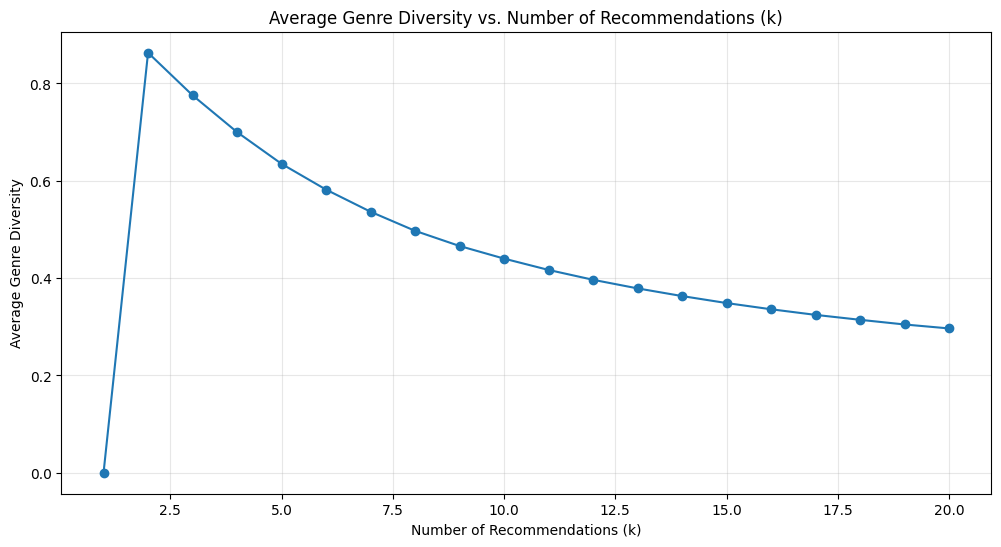


Average diversity at different k values:
k = 1: 0.0000
k = 5: 0.6349
k = 10: 0.4401
k = 15: 0.3487
k = 20: 0.2966

Example recommendations:

User 469574 recommendations:
1. Item 11103: Строительство домов на верхушках деревьев (документальное)
2. Item 10538: Ненужное кредо (русские, короткометражные)
3. Item 14260: Легендарные крушения Корсики (документальное)
4. Item 10191: Джекабара (комедии)
5. Item 4207: Сделай сам вместе с Ам Нямом (развлекательные, мультфильмы)
6. Item 3446: Подводное богатство Южной Африки. Южная Африка (документальное)
7. Item 1264: Ишь ты, масленица (мультфильм)
8. Item 15687: Береговая линия в 3 000 километров (документальное)
9. Item 3552: 5 % биоразнообразия Земли (документальное)
10. Item 180: [4К] Акулий рай (документальное)

User 648365 recommendations:
1. Item 7626: Мстители: Война бесконечности (боевики, фантастика, приключения)
2. Item 12173: Мстители: Финал (боевики, драмы, фантастика)
3. Item 6837: Крёстный отец (драмы)
4. Item 14317: Веном (популя

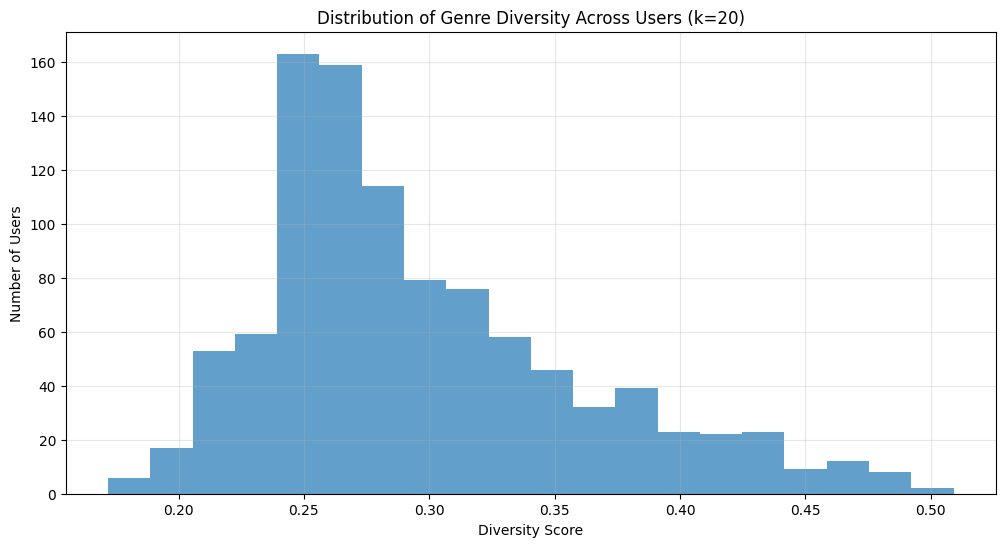


Average diversity across all users: 0.2966
Median diversity: 0.2800
Min diversity: 0.1719
Max diversity: 0.5091

Conclusion:
1. We trained three first-level models on all available data
2. Generated 50 candidates from each model for 1000 users
3. Merged candidates and calculated features for 148246 user-item pairs
4. Selected top-20 recommendations for each user based on the best ranker (XGBoost)
5. Analyzed diversity of recommendations at different k values
6. The average genre diversity across all users at k=20 is 0.2966


In [31]:
#6. diversity для разных k
k_values = list(range(1, k+1))
diversity_values = []

for current_k in tqdm(k_values, desc="Calculating diversity"):
    current_diversity = []
    
    for user_id, recommendations in top_recommendations.items():
        if len(recommendations) >= current_k:
            current_user_recs = recommendations[:current_k]
            user_diversity = calculate_diversity(current_user_recs, items, 'genres')
            current_diversity.append(user_diversity)

    if current_diversity:
        avg_diversity = np.mean(current_diversity)
    else:
        avg_diversity = 0
    
    diversity_values.append(avg_diversity)

plt.figure(figsize=(12, 6))
plt.plot(k_values, diversity_values, marker='o')
plt.title('Average Genre Diversity vs. Number of Recommendations (k)')
plt.xlabel('Number of Recommendations (k)')
plt.ylabel('Average Genre Diversity')
plt.grid(True, alpha=0.3)
plt.show()

print("\nAverage diversity at different k values:")
for i, current_k in enumerate([1, 5, 10, 15, k]):
    if current_k <= k:
        print(f"k = {current_k}: {diversity_values[current_k-1]:.4f}")

print("\nExample recommendations:")
for user_id in list(sample_users)[:3]:
    print(f"\nUser {user_id} recommendations:")
    for i, item_id in enumerate(top_recommendations.get(user_id, [])[:10], 1):
        title = items.loc[item_id, 'title'] if item_id in items.index else "Unknown"
        genres = items.loc[item_id, 'genres'] if item_id in items.index else "Unknown"
        print(f"{i}. Item {item_id}: {title} ({genres})")

user_diversity = {}
for user_id, recommendations in top_recommendations.items():
    if recommendations:
        user_diversity[user_id] = calculate_diversity(recommendations, items, 'genres')

plt.figure(figsize=(12, 6))
plt.hist(list(user_diversity.values()), bins=20, alpha=0.7)
plt.title(f'Distribution of Genre Diversity Across Users (k={k})')
plt.xlabel('Diversity Score')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nAverage diversity across all users: {np.mean(list(user_diversity.values())):.4f}")
print(f"Median diversity: {np.median(list(user_diversity.values())):.4f}")
print(f"Min diversity: {np.min(list(user_diversity.values())):.4f}")
print(f"Max diversity: {np.max(list(user_diversity.values())):.4f}")

# Заключение
print("\nConclusion:")
print(f"1. We trained three first-level models on all available data")
print(f"2. Generated {N} candidates from each model for {len(sample_users)} users")
print(f"3. Merged candidates and calculated features for {len(candidates_with_features)} user-item pairs")
print(f"4. Selected top-{k} recommendations for each user based on the best ranker ({model_name})")
print(f"5. Analyzed diversity of recommendations at different k values")
print(f"6. The average genre diversity across all users at k={k} is {np.mean(list(user_diversity.values())):.4f}")

In [32]:
# 7. Сохраняем результаты
simple_recommendations = []
for user_id, rec_items in top_recommendations.items():
    for rank, item_id in enumerate(rec_items, 1):
        simple_recommendations.append({
            'user_id': user_id,
            'item_id': item_id,
            'rank': rank
        })

simple_df = pd.DataFrame(simple_recommendations)
simple_filename = f"{model_name}_simple_recommendations_top{k}.csv"
simple_df.to_csv(simple_filename, index=False)
print(f"Simple recommendations saved to {simple_filename}")


Simple recommendations saved to XGBoost_simple_recommendations_top20.csv
